<a href="https://colab.research.google.com/github/RamSaw/NLP/blob/master/HW_04_NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import random
import os
import numpy as np
import torch
import nltk
import csv
import string
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
import re
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tnrange
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords

In [3]:
drive.mount('./gdrive')
PATH_TO_DATASET_IN_GDRIVE = './gdrive/My Drive/datasets_for_homeworks/train_qa.csv'

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [0]:
def make_reproducible(seed: int, make_cuda_reproducible: bool) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
SEED = 2361
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def find_sentence_with_answer(text, answer):
  answer_lowered = answer.lower()
  sentences = nltk.sent_tokenize(text, language="russian")
  num_of_sentences = len(sentences)
  # this check is needed because nltk.sent_tokenize splits abbreviations
  for i in range(num_of_sentences - 1):
      sentences.append(sentences[i] + " " + sentences[i + 1])
  for sentence in sentences:
      sentence_lowered = sentence.lower()
      if answer_lowered in sentence_lowered:
        return sentence, sentence_lowered.find(answer_lowered)
  
  return "", -1

In [8]:
find_sentence_with_answer('Джордж Д. Мартин родился в 1998 году. Вырос я в городе Санкт-Петербург.', 'Джордж Д. Мартин')

('Джордж Д. Мартин родился в 1998 году.', 0)

In [9]:
PUNCTUATION = [punct for punct in string.punctuation]
PUNCTUATION.append('...')
PUNCTUATION.append('..')
print(PUNCTUATION)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '...', '..']


In [0]:
def clear_answer_from_punctuation(answer):
    answer = answer.strip()
    for punct in PUNCTUATION:
        if answer.startswith(punct):
            answer = answer[len(punct):]
    for punct in PUNCTUATION:
        if answer.endswith(punct):
            answer = answer[:-len(punct)]
    return answer

In [0]:
DATASET = []
with open(PATH_TO_DATASET_IN_GDRIVE) as csv_file:
    reader = csv.reader(csv_file)
    next(reader) # skip header

    for row in reader:
        paragraph = row[2]
        question = row[3]
        answer = row[4]
        answer = clear_answer_from_punctuation(answer)
        sentence, start_ind = find_sentence_with_answer(paragraph, answer)
        if start_ind != -1:
            DATASET.append({'paragraph': re.split('(\W)', sentence),
                            'question': re.split('(\W)', question),
                            'answer': (start_ind, len(answer))})

In [12]:
print(DATASET[10])
print(len(DATASET))

{'paragraph': ['Средняя', ' ', 'его', ' ', 'масса', ' ', '1300', '—', '1400', ' ', 'г', '.', '', ' ', 'Рост', ' ', 'мозга', ' ', 'продолжается', ' ', 'до', ' ', '20', ' ', 'лет', '.', ''], 'question': ['Сколько', ' ', 'лет', ' ', 'происходит', ' ', 'развитие', ' ', 'мозговой', ' ', 'массы', '?', ''], 'answer': (55, 9)}
50359


In [0]:
STEMMER = SnowballStemmer("russian")
def preprocess(word, use_stemmer=True):
  return STEMMER.stem(word.lower()) if use_stemmer else word.lower()

def build_vocab(data):
    vocab = defaultdict(lambda: 0)
    vocab['<unk>'] = 0
    vocab['<sep>'] = 1
    vocab['<pad>'] = 2
    for datapoint in tqdm(data):
        for word in datapoint['paragraph'] + datapoint['question']:
            word_preprocessed = preprocess(word)
            if word_preprocessed not in vocab:
                vocab[word_preprocessed] = len(vocab)
    return vocab

In [14]:
VOCAB = build_vocab(DATASET)

In [15]:
print(len(VOCAB))
print(VOCAB['<unk>'])
print(VOCAB['<sep>'])
print(VOCAB['<pad>'])
print(VOCAB['средн'])
print(VOCAB['средняя'])

52387
0
1
2
229
0


In [0]:
def to_tensor(datapoint, vocab):
    indices = [vocab[preprocess(word)] for word in datapoint['paragraph'] + ['<sep>'] + datapoint['question']]
    return torch.tensor(indices)

def pad_dataset(dataset, vocab):
    num_dataset = [to_tensor(datapoint, vocab) for datapoint in tqdm(dataset)]
    return pad_sequence(num_dataset, batch_first=True, padding_value=vocab['<pad>'])

In [17]:
PAD_DATASET = pad_dataset(DATASET, VOCAB)

In [18]:
PAD_DATASET[10]

tensor([229,   4, 230,  ...,   2,   2,   2])

In [0]:
def get_positions(datapoint):
    pos = []
    idx = 0
    for word in datapoint['paragraph']:
        cur_l = len(word)
        pos.append((idx, cur_l))
        idx += cur_l
    return pos

In [0]:
def pos_dataset(dataset):
    return [get_positions(datapoint) for datapoint in tqdm(dataset)]

In [21]:
POS_DATASET = pos_dataset(DATASET)

In [22]:
POS_DATASET[10]

[(0, 7),
 (7, 1),
 (8, 3),
 (11, 1),
 (12, 5),
 (17, 1),
 (18, 4),
 (22, 1),
 (23, 4),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 0),
 (30, 1),
 (31, 4),
 (35, 1),
 (36, 5),
 (41, 1),
 (42, 12),
 (54, 1),
 (55, 2),
 (57, 1),
 (58, 2),
 (60, 1),
 (61, 3),
 (64, 1),
 (65, 0)]

In [0]:
def add_labels_to_dataset(X_pad, X_pos, dataset):
    dataset_with_labels = []

    for sentence, pos, row in zip(X_pad, X_pos, dataset):
        ans_start, ans_len = row['answer']
        y = torch.zeros(2)
        for pos_i in range(len(pos)):
          if pos[pos_i][0] == ans_start:
              y[0] = pos_i
          if pos[pos_i][0] == ans_start + ans_len:
              y[1] = pos_i - 1
        dataset_with_labels.append((sentence, y))

    return dataset_with_labels

In [0]:
LABELED_DATASET = add_labels_to_dataset(PAD_DATASET, POS_DATASET, DATASET)

In [25]:
LABELED_DATASET[20]

(tensor([383,   4, 384,  ...,   2,   2,   2]), tensor([0., 6.]))

In [0]:
TRAIN_DATASET, VAL_DATASET = train_test_split(LABELED_DATASET, test_size=0.1, random_state=SEED)

In [0]:
class QA_Model(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(QA_Model, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, 2)
        self.log_softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x):
        x = self.word_embeddings(x)
        x, _ = self.lstm(x)
        y = self.linear(x)
        y = torch.transpose(y, 1, 2)
        y = self.log_softmax(y)
        return y

In [0]:
def fit(model, train_data, val_data, epoch_cnt, batch_size):
    loss_function = nn.NLLLoss()

    def my_loss_function(output, y):
        y1, y2 = y[:, 0].reshape(-1), y[:, 1].reshape(-1)
        loss1 = loss_function(output[:, 0], y1.long())
        loss2 = loss_function(output[:, 1], y2.long())
        return (loss1 + loss2) / 2
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        for batch in train_loader:
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad()
            output = model(x.long())
            loss = my_loss_function(output, y)
            loss.backward()

            train_loss_values.append(loss.item())
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

        with torch.no_grad():
            loss_values = []
            for batch_data in val_loader:
                x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
                output = model(x.long())
                loss = my_loss_function(output, y)
                loss_values.append(loss.item())
            val_loss_values.append(np.mean(np.array(loss_values)))

    return train_loss_values, val_loss_values 


In [0]:
HID_DIM = 128
EMB_DIM = 128
MODEL = QA_Model(EMB_DIM, HID_DIM, len(VOCAB)).to(DEVICE)

In [48]:
EPOCHS_NUM = 7
BATCH_SIZE = 256
TRAIN_LOSS, VAL_LOSS = fit(MODEL, TRAIN_DATASET, VAL_DATASET, EPOCHS_NUM, BATCH_SIZE)

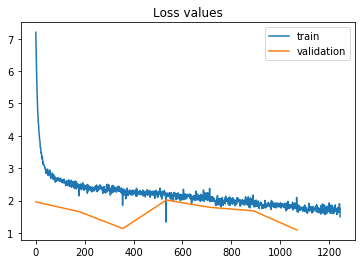

In [49]:
plt.plot(TRAIN_LOSS, label='train')
plt.plot(np.arange(0, len(TRAIN_LOSS), len(TRAIN_LOSS) / EPOCHS_NUM), VAL_LOSS, label='validation')
plt.legend()
plt.title("Loss values")
plt.show()

In [50]:
nltk.download('stopwords')
STOPWORDS = list(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def proccess_sentence(sentence):
  return ' '.join([preprocess(word) for word in nltk.word_tokenize(sentence) if word.lower() not in STOPWORDS])

def find_closest_tf_idf(paragraph, question):
  sentences = nltk.sent_tokenize(paragraph)
  sentences_preproccessed = sentences + [question]
  sentences_preproccessed = [proccess_sentence(sentence) for sentence in sentences_preproccessed]
  tf_idf = TfidfVectorizer().fit_transform(sentences_preproccessed)

  question_vec = tf_idf[-1].todense()
  minimum = (cosine(tf_idf[0].todense(), question_vec), 0)
  for i in range(1, len(sentences)):
    if cosine(tf_idf[i].todense(), question_vec) < minimum[0]:
        minimum = (cosine(tf_idf[i].todense(), question_vec), i)
  return sentences[minimum[1]]

In [0]:
TEST = []

with open('dataset_281937.txt') as test_csv:
    reader = csv.reader(test_csv, delimiter='\t')
    next(reader)
    for row in reader:
        question = row[3]
        sentence = find_closest_tf_idf(row[2], question)
        try:
            TEST.append({'paragraph': re.split('(\W)', sentence),
                        'question_id': row[1],
                        'question': re.split('(\W)', question)})
        except:
            print(sentence)

In [66]:
PAD_TEST = pad_dataset(TEST, VOCAB)
POS_TEST = pos_dataset(TEST)

In [67]:
print(TEST[20])

{'paragraph': ['Капуцины', ',', '', ' ', 'наоборот', ',', '', ' ', 'имеют', ' ', 'очень', ' ', 'широкий', ' ', 'диапазон', ' ', 'пищи', ',', '', ' ', 'который', ' ', 'включает', ' ', 'фрукты', ',', '', ' ', 'листья', ',', '', ' ', 'цветы', ',', '', ' ', 'бутоны', ',', '', ' ', 'нектар', ',', '', ' ', 'семена', ',', '', ' ', 'насекомых', ' ', 'и', ' ', 'других', ' ', 'беспозвоночных', ',', '', ' ', 'птичьи', ' ', 'яйца', ' ', 'и', ' ', 'мелких', ' ', 'позвоночных', ' ', '', '(', 'в', ' ', 'том', ' ', 'числе', ' ', 'птиц', ',', '', ' ', 'ящериц', ',', '', ' ', 'белок', ' ', 'и', ' ', 'летучих', ' ', 'мышей', ')', '', '[', '10', ']', '', '.', ''], 'question_id': '52527', 'question': ['Каких', ' ', 'мелких', ' ', 'позвоночных', ' ', 'едят', ' ', 'капуцины', '?', '']}


In [0]:
def get_answers():
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(PAD_TEST, batch_size=256)
        answers = None
        
        for batch in test_loader:
            x = batch.to(DEVICE)
            output = MODEL(x.long())
            _, answer_cur = output.max(dim=2)
            answer_cur = answer_cur.cpu().numpy()
            if answers is None:
                answers = answer_cur
            else:
                answers = np.append(answers, answer_cur, axis=0)
        return answers

In [0]:
ANSWERS = get_answers()

In [0]:
with open('./output.txt', 'w') as output_file:
    for tags, row in zip(ANSWERS, TEST):
        start, end = tags
        if start > end:
            start, end = end, start
        answer_to_print = "".join(row['paragraph'][start:end + 1])
        output_file.write(f"{row['question_id']}\t{answer_to_print}\n")
